In [1]:
import build.python.pyschedlib as sc
import scripts.schedsim as sm

import os
import shutil
import matplotlib.pyplot as plt
import polars as pl
import subprocess
from concurrent.futures import ThreadPoolExecutor
from io import StringIO
import numpy as np
import json as js

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)

SCHEDVIEW = "./build/apps/schedview"
sim = sm.SchedSimRunner("./build/apps/schedsim")

In [10]:
PLATFORM = "platforms/exynos5422.json"
DIR = "alloc_tasksets"
UTILIZATION = 6.5
LITTLE_PERF_SCORE = 0.33334

#targets = [round(x*0.1, 1) for x in range(1, int(LITTLE_PERF_SCORE*10)+1)];
#targets = [0.1, 0.2, 0.3, LITTLE_PERF_SCORE]
configs = [
    ( "ff_lb", "grub", 0.22 ),
    ( "little_first", "grub", 0.22 ),
    ( "smart_ass", "grub", 0.05 ),
    ( "smart_ass", "grub", 0.1 ),
    ( "smart_ass", "grub", 0.15 ),
    ( "smart_ass", "grub", 0.2 ),
    ( "smart_ass", "grub", 0.25 ),
    ( "smart_ass", "grub", 0.3 ),
    ( "smart_ass", "grub", 0.33334 )
]
configs

[('ff_lb', 'grub', 0.22),
 ('little_first', 'grub', 0.22),
 ('smart_ass', 'grub', 0.05),
 ('smart_ass', 'grub', 0.1),
 ('smart_ass', 'grub', 0.15),
 ('smart_ass', 'grub', 0.2),
 ('smart_ass', 'grub', 0.25),
 ('smart_ass', 'grub', 0.3),
 ('smart_ass', 'grub', 0.33334)]

In [3]:
plat = {}
with open(PLATFORM, 'r') as f:
    plat = js.loads("".join(f.readlines()))

plat

{'clusters': [{'effective_freq': 1200.0,
   'frequencies': [200.0,
    400.0,
    600.0,
    800.0,
    1000.0,
    1200.0,
    1400.0,
    1600.0,
    1800.0,
    2000.0,
    2100.0],
   'power_model': [0.04433100178,
    3.410453667e-06,
    2.193142733e-08,
    4.609381282e-11],
   'procs': 4,
   'perf_score': 1.0},
  {'effective_freq': 600.0,
   'frequencies': [200.0, 400.0, 600.0, 800.0, 1000.0, 1200.0, 1300.0, 1400.0],
   'power_model': [0.04433100178,
    3.410453667e-06,
    2.193142733e-08,
    4.609381282e-11],
   'procs': 4,
   'perf_score': 0.3334}]}

# Generate the tasksets

In [4]:
if os.path.isdir(DIR):
    shutil.rmtree(DIR)

os.mkdir(DIR)

util_steps = list(reversed(range(1, int(UTILIZATION*10)+1, 2)))
NB_JOBS = 100
NB_TASK = 50
UMAX    = 0.8 #LITTLE_PERF_SCORE - 0.13334

for i in util_steps:
    data_path = f"{DIR}/{str(i)}"
    os.mkdir(data_path)
    utilization = round(i * 0.1, 1)
    print(f"jobs = {NB_JOBS}, tasks = {NB_TASK}, umax = {UMAX}, utilization = {utilization}")
    sc.generate_tasksets(data_path, NB_JOBS, NB_TASK, utilization, UMAX, success_rate = 1.0, compression_rate = 1.0, nb_cores = 16, a_special_need=(0.0, 0.22))

print("== finished ==")

jobs = 100, tasks = 50, umax = 0.8, utilization = 6.5
jobs = 100, tasks = 50, umax = 0.8, utilization = 6.3
jobs = 100, tasks = 50, umax = 0.8, utilization = 6.1
jobs = 100, tasks = 50, umax = 0.8, utilization = 5.9
jobs = 100, tasks = 50, umax = 0.8, utilization = 5.7
jobs = 100, tasks = 50, umax = 0.8, utilization = 5.5
jobs = 100, tasks = 50, umax = 0.8, utilization = 5.3
jobs = 100, tasks = 50, umax = 0.8, utilization = 5.1
jobs = 100, tasks = 50, umax = 0.8, utilization = 4.9
jobs = 100, tasks = 50, umax = 0.8, utilization = 4.7
jobs = 100, tasks = 50, umax = 0.8, utilization = 4.5
jobs = 100, tasks = 50, umax = 0.8, utilization = 4.3
jobs = 100, tasks = 50, umax = 0.8, utilization = 4.1
jobs = 100, tasks = 50, umax = 0.8, utilization = 3.9
jobs = 100, tasks = 50, umax = 0.8, utilization = 3.7
jobs = 100, tasks = 50, umax = 0.8, utilization = 3.5
jobs = 100, tasks = 50, umax = 0.8, utilization = 3.3
jobs = 100, tasks = 50, umax = 0.8, utilization = 3.1
jobs = 100, tasks = 50, umax

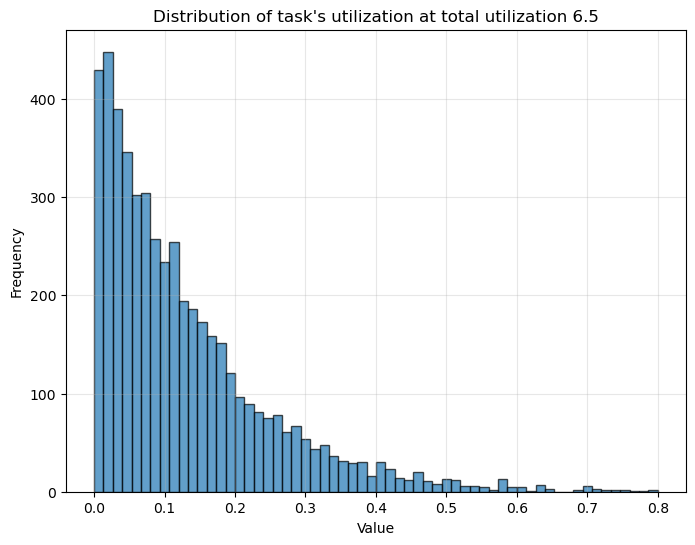

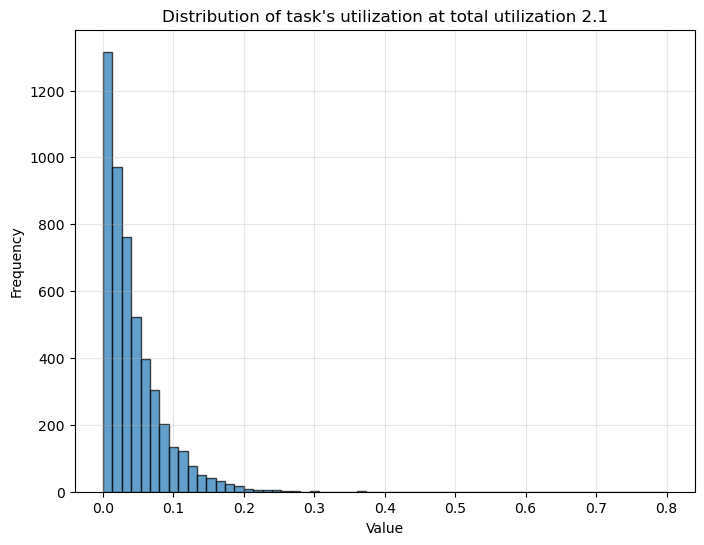

In [5]:
bins = np.linspace(0, UMAX, num=61)
values = []
for i in range(1, 101):
    lines = []
    with open(f"{DIR}/65/{str(i)}.json", "r") as f:
        lines = f.readlines()
    file_values = [t.utilization for t in sc.from_json_setting(lines[0]).tasks]
    values += file_values

plt.figure(figsize=(8, 6))
plt.hist(values, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of task\'s utilization at total utilization 6.5')
plt.grid(True, alpha=0.3)
plt.show()

values = []
for i in range(1, 101):
    lines = []
    with open(f"{DIR}/21/{str(i)}.json", "r") as f:
        lines = f.readlines()
    file_values = [t.utilization for t in sc.from_json_setting(lines[0]).tasks]
    values += file_values

plt.figure(figsize=(8, 6))
plt.hist(values, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of task\'s utilization at total utilization 2.1')
plt.grid(True, alpha=0.3)
plt.show()

# Simulate the tasksets

In [6]:
for conf in configs:
    print(f"-> logs_{conf[0]}_{conf[1]}_{conf[2]}")
    sim.simul(DIR, conf[0], conf[1], PLATFORM, conf[2], f"{DIR}_logs_{conf[0]}_{conf[1]}_{conf[2]}")

print("== finished ==")

-> logs_ff_lb_grub_0.22
-> logs_little_first_grub_0.22
-> logs_smart_ass_grub_0.05
-> logs_smart_ass_grub_0.1
-> logs_smart_ass_grub_0.15
-> logs_smart_ass_grub_0.2
-> logs_smart_ass_grub_0.25
-> logs_smart_ass_grub_0.3
-> logs_smart_ass_grub_0.33334
== finished ==


-> logs_smart_ass_grub_0.6


# Logs analysis

In [7]:
def compute_stats(logs_dir):
    args = [SCHEDVIEW, "--platform", PLATFORM, "-d", logs_dir, "--index", "--arrivals", "--rejected", "--deadlines-counts", "--cmigration", "--transitions", "--duration"]
    try:
        df_res = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
    except subprocess.CalledProcessError as e:
        print(f"CalledProcessError: {str.join(" ", e.cmd)} | {e.stdout}")
        raise e

    df_res = df_res.with_columns((pl.col("file").str.extract(r"(\w+).json").cast(pl.Int32)).alias("id")).drop("file")
    df_energy = pl.DataFrame({
        "c1-energy": [],
        "c2-energy": []
    }, schema={"c1-energy": pl.Float64, "c2-energy": pl.Float64})
    for i in range(1, 101):
        args = [SCHEDVIEW, "--platform", PLATFORM, f"{logs_dir}/{i}.json", "--index", "--energy"]
        df = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
        df = pl.DataFrame({"c1-energy": df["energy_consumption"][0], "c2-energy": df["energy_consumption"][1]})
        df_energy = pl.concat([df_energy, df])

    df_util = pl.DataFrame({
        "c1-util": [],
        "c2-util": []
    }, schema={"c1-util": pl.Float64, "c2-util": pl.Float64})
    for i in range(1, 101):
        args = [SCHEDVIEW, "--platform", PLATFORM, f"{logs_dir}/{i}.json", "--index", "--util"]
        df = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
        df = pl.DataFrame({"c1-util": df["util"][0], "c2-util": df["util"][1]})
        df_util = pl.concat([df_util, df])

    return pl.concat([df_res, df_energy, df_util], how="horizontal")

stats = {}
for index,conf in enumerate(configs):
    print(f"-> {conf[0]} {conf[1]} {conf[2]}")
    stats[index] = {}
    stats_df = []

    def compute_utilization_step(i):
        return compute_stats(f"{DIR}_logs_{conf[0]}_{conf[1]}_{conf[2]}/{i}").with_columns(utilizations=i/10)

    with ThreadPoolExecutor() as executor:
        stats_df = list(executor.map(compute_utilization_step, util_steps))

    stats[index] = pl.concat(stats_df).select(["utilizations", "id", pl.exclude(["utilizations", "id"])]).sort(["utilizations", "id"])

print("== finished ==")

-> ff_lb grub 0.22
-> little_first grub 0.22
-> smart_ass grub 0.05
-> smart_ass grub 0.1
-> smart_ass grub 0.15
-> smart_ass grub 0.2
-> smart_ass grub 0.25
-> smart_ass grub 0.3
-> smart_ass grub 0.33334
== finished ==


In [8]:
results = {}
for i,_ in enumerate(configs):
    results[i] = (stats[i].with_columns(
        (1 - (pl.col("rejected") / pl.col("arrivals"))).alias("accepted-rates"),
        (1 - (pl.col("deadlines-counts") / (pl.col("arrivals") - pl.col("rejected")))).alias("meet-rates"),
        (pl.col("cmigration") / pl.col("transitions")).alias("migration-rates"),
        (pl.col("c1-energy") / pl.col("duration")).alias("c1-power"),
        (pl.col("c2-energy") / pl.col("duration")).alias("c2-power"),
        (pl.col("c1-energy") / pl.col("duration") + pl.col("c2-energy") / pl.col("duration")).alias("total-power"),
        (pl.col("c1-util") + pl.col("c2-util")).alias("total-util")
    ).group_by("utilizations").agg(
        pl.col("accepted-rates").mean(),
        pl.col("meet-rates").mean(),
        pl.col("migration-rates").mean(),
        pl.col("c1-power").mean(),
        pl.col("c2-power").mean(),
        pl.col("total-power").mean(),
        pl.col("c1-util").mean(),
        pl.col("c2-util").mean(),
        pl.col("total-util").mean()
    ))

energy = pl.concat([
    stats[i].select(["utilizations", "id", "c1-energy", "c2-energy"]).rename({"c1-energy": f"c1-energy-{str(i)}", "c2-energy": f"c2-energy-{str(i)}"}) for i, _ in enumerate(configs)
], how="align")

energy_diff = energy.with_columns(
    [(pl.col(f"{clu}-energy-{str(i)}") - pl.col(f"{clu}-energy-{str(1)}")).alias(f"{clu}-energy-{str(i)}-diff") for i, _ in enumerate(configs) for clu in ["c1", "c2"]],
).with_columns(
    [(pl.col(f"c1-energy-{str(i)}-diff") + pl.col(f"c2-energy-{str(i)}-diff")).alias(f"energy-{str(i)}-diff") for i,_ in enumerate(configs)]
).group_by("utilizations").agg(
    pl.exclude(["utilizations", "id"]).mean()
)

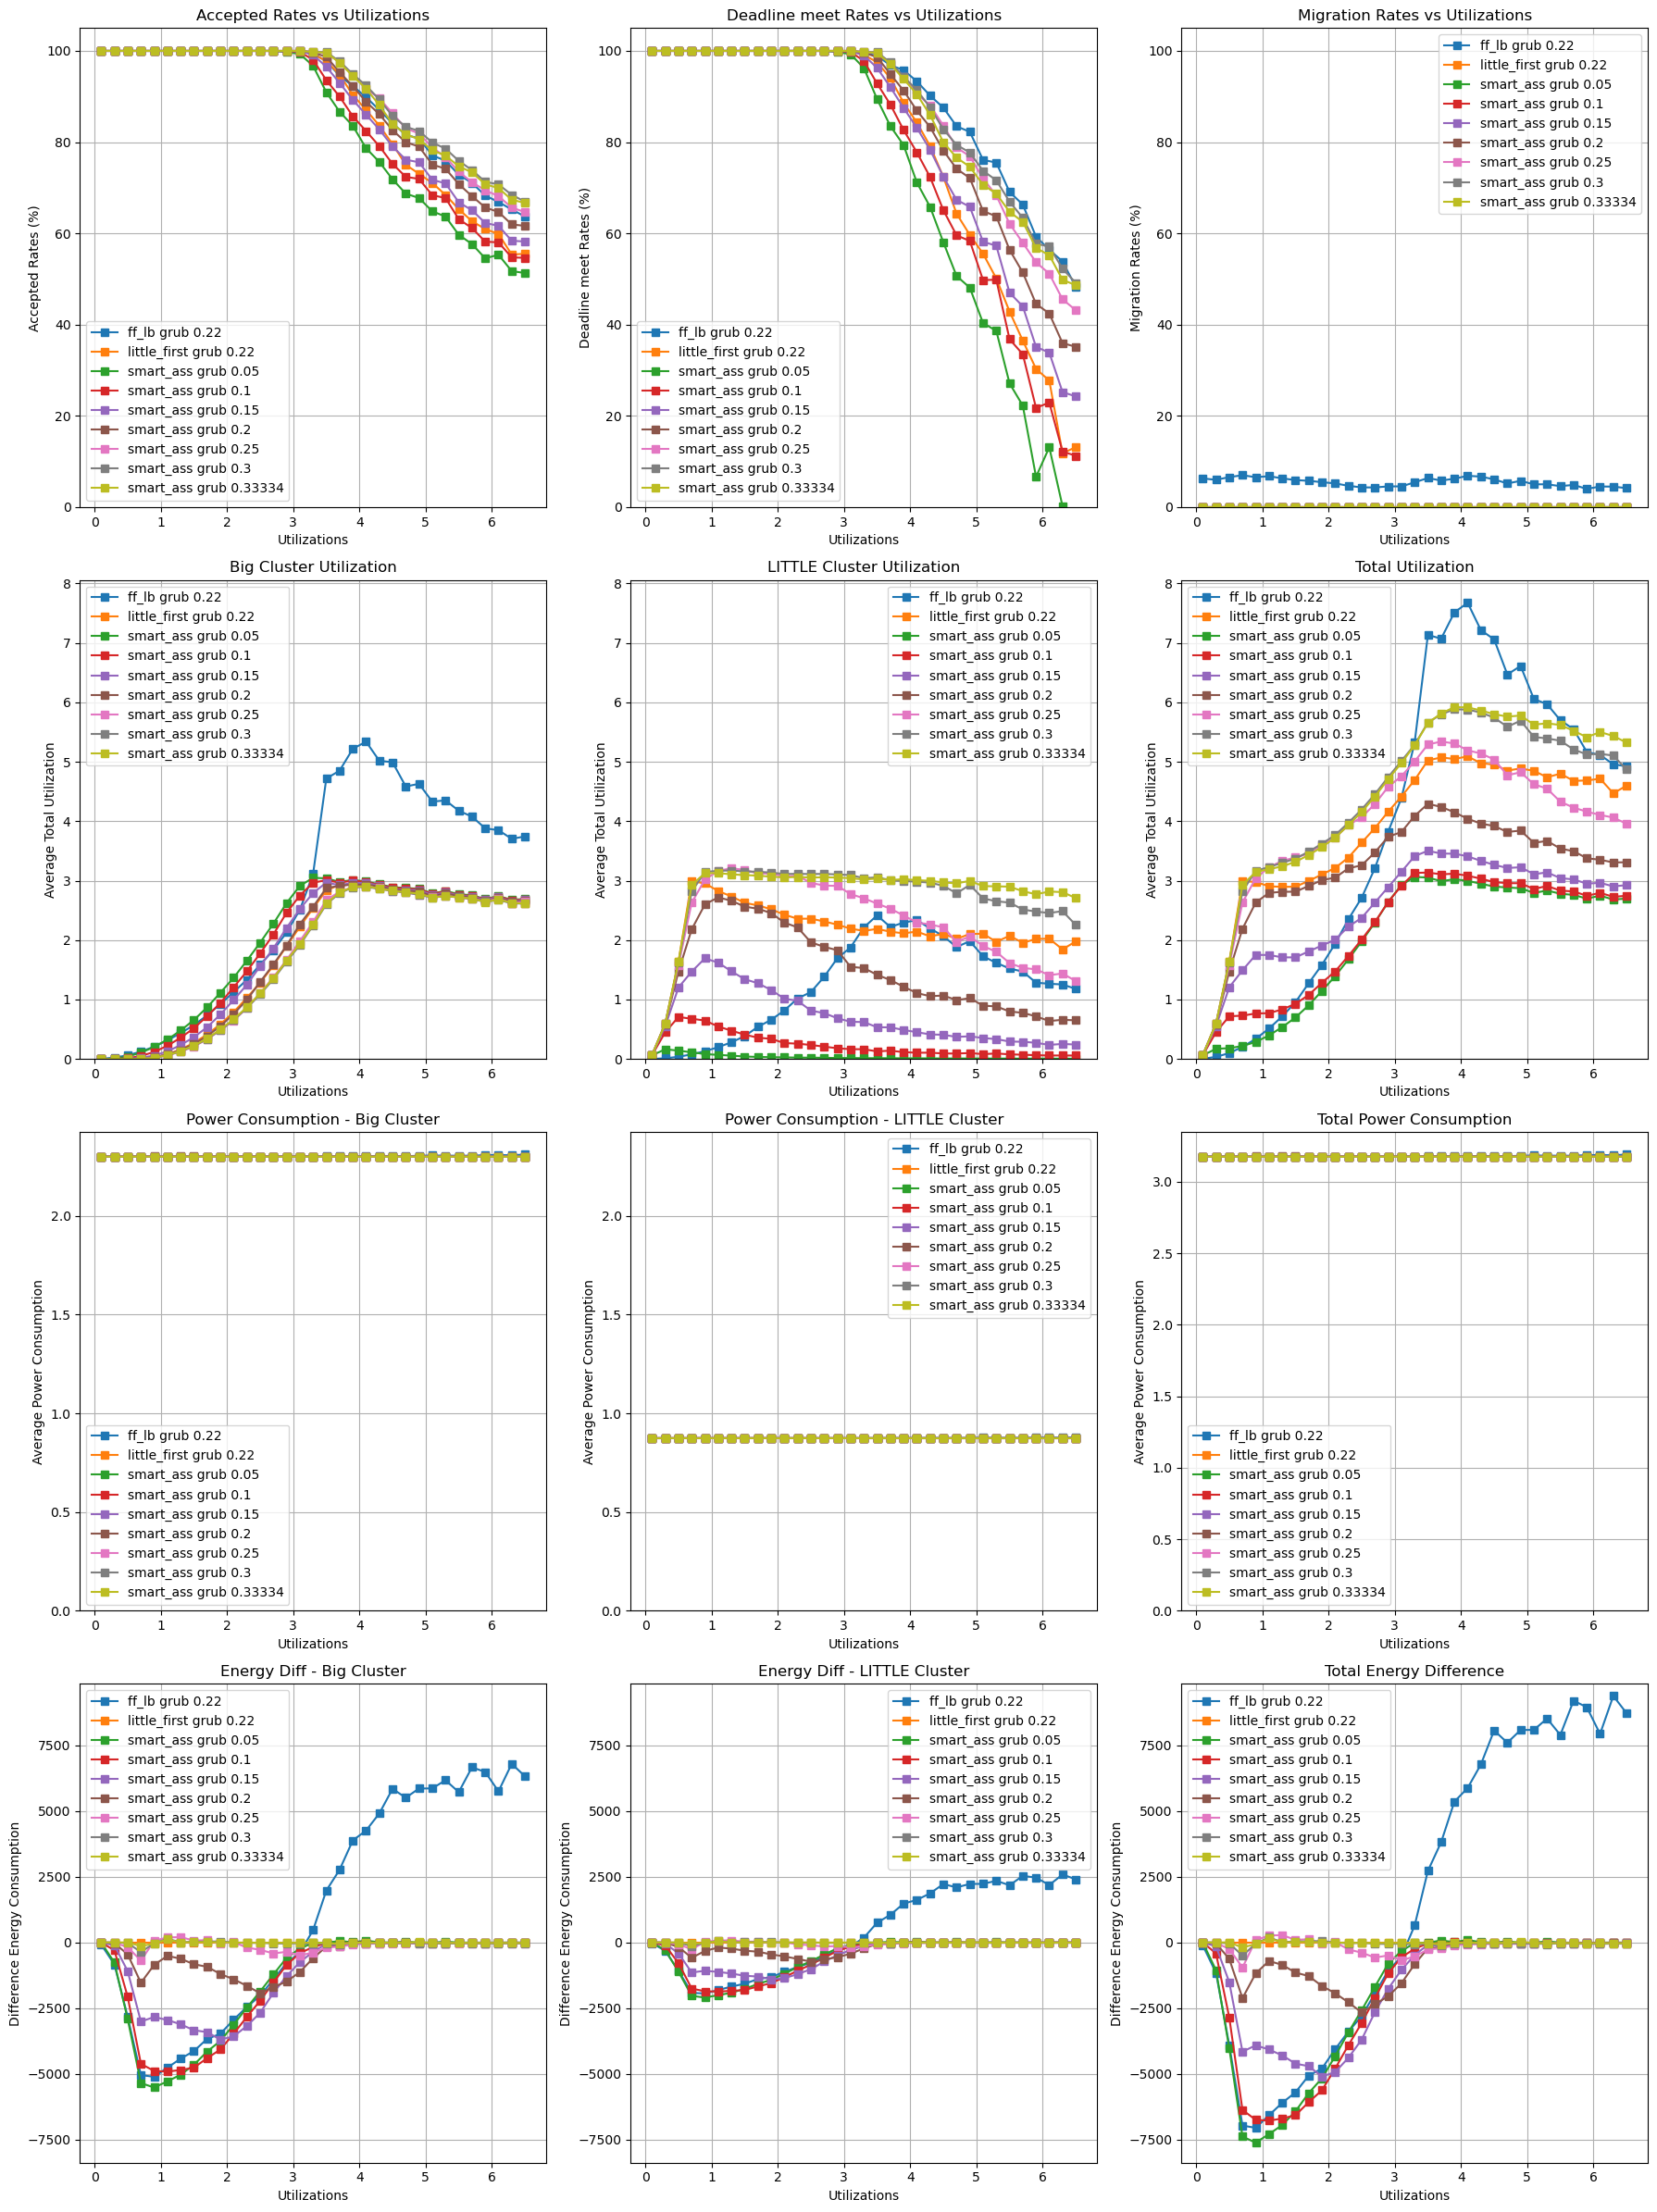

In [9]:
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
axes = axes.flatten()

axe=0
for i, c in enumerate(configs):
    axes[axe].plot(results[i]["utilizations"], results[i]["accepted-rates"] * 100, label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_ylim(0, 105)
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Accepted Rates (%)")
axes[axe].set_title("Accepted Rates vs Utilizations")
axes[axe].legend()
axes[axe].grid(True)

axe=1
for i, c in enumerate(configs):
    axes[axe].plot(results[i]["utilizations"], results[i]["meet-rates"] * 100, label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_ylim(0, 105)
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Deadline meet Rates (%)")
axes[axe].set_title("Deadline meet Rates vs Utilizations")
axes[axe].legend()
axes[axe].grid(True)

axe=2
for i, c in enumerate(configs):
    axes[axe].plot(results[i]["utilizations"], results[i]["migration-rates"] * 100, label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_ylim(0, 105)
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Migration Rates (%)")
axes[axe].set_title("Migration Rates vs Utilizations")
axes[axe].legend()
axes[axe].grid(True)

axe=3
for i, c in enumerate(configs):
    axes[axe].plot(results[i]["utilizations"], results[i]["c1-util"], label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_ylim(0, max([results[i]["total-util"].max() for i, _ in enumerate(configs)]) * 1.05)
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Average Total Utilization")
axes[axe].set_title("Big Cluster Utilization")
axes[axe].legend()
axes[axe].grid(True)

axe=4
for i, c in enumerate(configs):
    axes[axe].plot(results[i]["utilizations"], results[i]["c2-util"], label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_ylim(0, max([results[i]["total-util"].max() for i, _ in enumerate(configs)]) * 1.05)
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Average Total Utilization")
axes[axe].set_title("LITTLE Cluster Utilization")
axes[axe].legend()
axes[axe].grid(True)

axe=5
for i, c in enumerate(configs):
    axes[axe].plot(results[i]["utilizations"], results[i]["total-util"], label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_ylim(0, max([results[i]["total-util"].max() for i, _ in enumerate(configs)]) * 1.05)
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Average Total Utilization")
axes[axe].set_title("Total Utilization")
axes[axe].legend()
axes[axe].grid(True)

axe=6
for i, c in enumerate(configs):
    axes[axe].plot(results[i]["utilizations"], results[i]["c1-power"], label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_ylim(0, max([results[i]["c1-power"].max() for i, _ in enumerate(configs)]) * 1.05)
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Average Power Consumption")
axes[axe].set_title("Power Consumption - Big Cluster")
axes[axe].legend()
axes[axe].grid(True)

axe=7
for i, c in enumerate(configs):
    axes[axe].plot(results[i]["utilizations"], results[i]["c2-power"], label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_ylim(0, max([results[i]["c1-power"].max() for i, _ in enumerate(configs)]) * 1.05)
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Average Power Consumption")
axes[axe].set_title("Power Consumption - LITTLE Cluster")
axes[axe].legend()
axes[axe].grid(True)

axe=8
for i, c in enumerate(configs):
    axes[axe].plot(results[i]["utilizations"], results[i]["total-power"], label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_ylim(0, max([results[i]["total-power"].max() for i, _ in enumerate(configs)]) * 1.05)
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Average Power Consumption")
axes[axe].set_title("Total Power Consumption")
axes[axe].legend()
axes[axe].grid(True)

max_y = max(energy_diff.select(pl.col(r"^energy.*diff$")).max().with_columns(pl.max_horizontal("*").alias("max"))["max"]) * 1.05
min_y = max(energy_diff.select(pl.col(r"^energy.*diff$")).min().with_columns(pl.min_horizontal("*").alias("min"))["min"]) * 1.10

axe=9
for i, c in enumerate(configs):
    axes[axe].plot(energy_diff["utilizations"], energy_diff[f"c1-energy-{i}-diff"], label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Difference Energy Consumption")
axes[axe].set_title("Energy Diff - Big Cluster")
axes[axe].set_ylim(min_y, max_y)
axes[axe].legend()
axes[axe].grid(True)

axe=10
for i, c in enumerate(configs):
    axes[axe].plot(energy_diff["utilizations"], energy_diff[f"c2-energy-{i}-diff"], label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Difference Energy Consumption")
axes[axe].set_title("Energy Diff - LITTLE Cluster")
axes[axe].set_ylim(min_y, max_y)
axes[axe].legend()
axes[axe].grid(True)

axe=11
for i, c in enumerate(configs):
    axes[axe].plot(energy_diff["utilizations"], energy_diff[f"energy-{i}-diff"], label=f"{c[0]} {c[1]} {c[2]}", marker='s')
axes[axe].set_xlabel("Utilizations")
axes[axe].set_ylabel("Difference Energy Consumption")
axes[axe].set_title("Total Energy Difference")
axes[axe].set_ylim(min_y, max_y)
axes[axe].legend()
axes[axe].grid(True)

plt.tight_layout()
plt.show()